In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
nordpool = pd.read_csv(r'C:\Users\Lenovo\Documents\MeusProjetos\Analise-Sincronia-SeriesTemporais-Soja\NP.csv', usecols=["Date", " Price"])
nordpool

,Date,Price
0,2013-01-01 00:00:00,31.05
1,2013-01-01 01:00:00,30.47
2,2013-01-01 02:00:00,28.92
3,2013-01-01 03:00:00,27.88
4,2013-01-01 04:00:00,26.96
...,...,...
52411,2018-12-24 19:00:00,50.72
52412,2018-12-24 20:00:00,49.86
52413,2018-12-24 21:00:00,49.09
52414,2018-12-24 22:00:00,49.02


In [3]:
nordpool['Date'] = pd.to_datetime(nordpool['Date'])
nordpool['Date'] = nordpool['Date'].dt.strftime("%d/%m/%Y")
nordpool['Date'] = pd.to_datetime(nordpool['Date'], format='mixed')
nordpool = nordpool.rename(columns={'Date':'DATA'})
nordpool = nordpool.set_index('DATA')

<Axes: xlabel='DATA'>

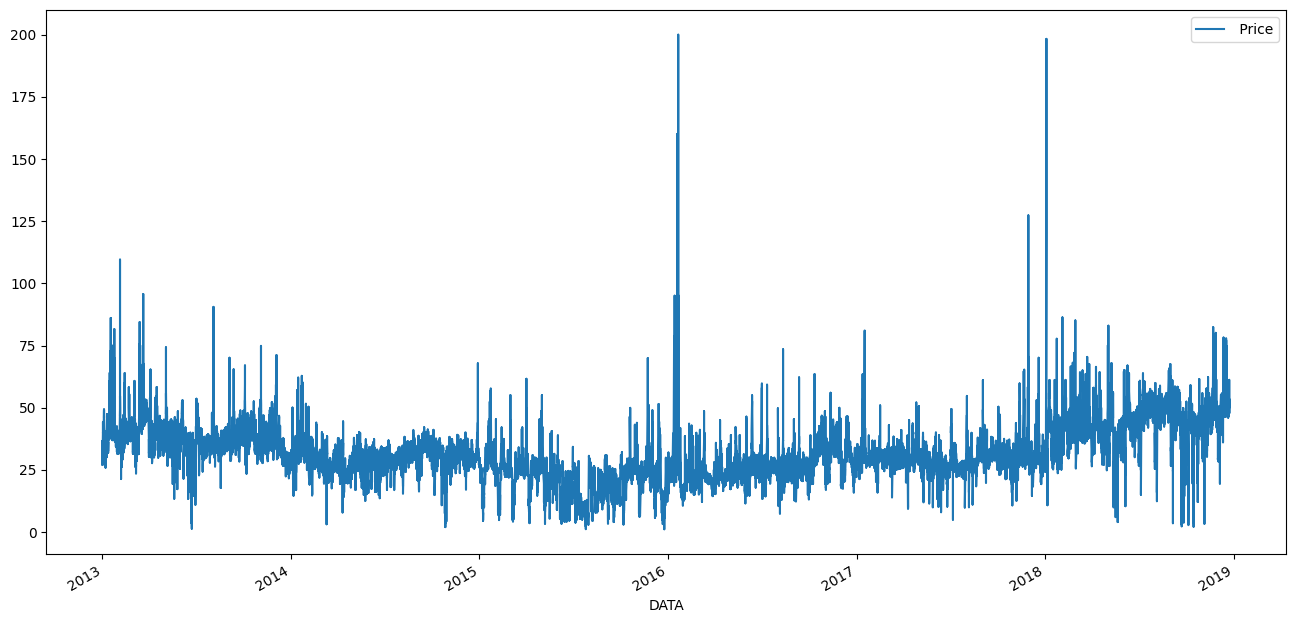

In [4]:
nordpool.plot(figsize=(16,8))

# Análise de estacionariedade

## Dickey-Fuller

In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Critical Value ({key})"] = value
    print(dfoutput)


adf_test(nordpool) #série não estacionária se p-value > 0.05

Results of Dickey-Fuller Test:
Test Statistic                -6.986401e+00
p-value                        7.948180e-10
#Lags Used                     5.800000e+01
Number of Observations Used    5.235700e+04
Critical Value (1%)           -3.430475e+00
Critical Value (5%)           -2.861595e+00
Critical Value (10%)          -2.566799e+00
dtype: float64


## KPSS

In [6]:
def kpss_test(x, h0_type='c'):
  indices = ['Estatística do teste', 'valor-p', '# de Lags']
  kpss_test = kpss(x, regression=h0_type, nlags="legacy")
  results = pd.Series(kpss_test[0:3], index=indices)
  print('H0: A série temporal é estacionária (caso valor-p > 0.05)')
  for key, value in kpss_test[3].items():
    results[f'Critical Value ({key})'] = value
  
  return results

In [7]:
kpss_test(nordpool)  #série não estacionária, p-value < 0.05

H0: A série temporal é estacionária (caso valor-p > 0.05)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_472\699921468.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(x, regression=h0_type, nlags="legacy")


Estatística do teste     15.301313
valor-p                   0.010000
# de Lags                58.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Identificada estacionariedade por Dickey-Fuller, porém, KPSS indicou não estacionariedade. Isso pode indicar que, mesmo que os dados sejam não estacionários, já que há uma leve tendência de aumento perceptível, a série temporal talvez demonstre algum comportamento estacionário.

# Amplitude e fase

In [8]:
nordpool_fft = np.fft.fft(nordpool)
nordpool_ifft = np.fft.ifft(nordpool_fft) / np.size(nordpool[' Price'])

amp = np.abs(nordpool_ifft)

fase = np.arctan2(np.imag(nordpool_ifft), np.real(nordpool_ifft))

fase_acm = np.unwrap(fase)

In [9]:
nordpool['Amplitude'] = amp

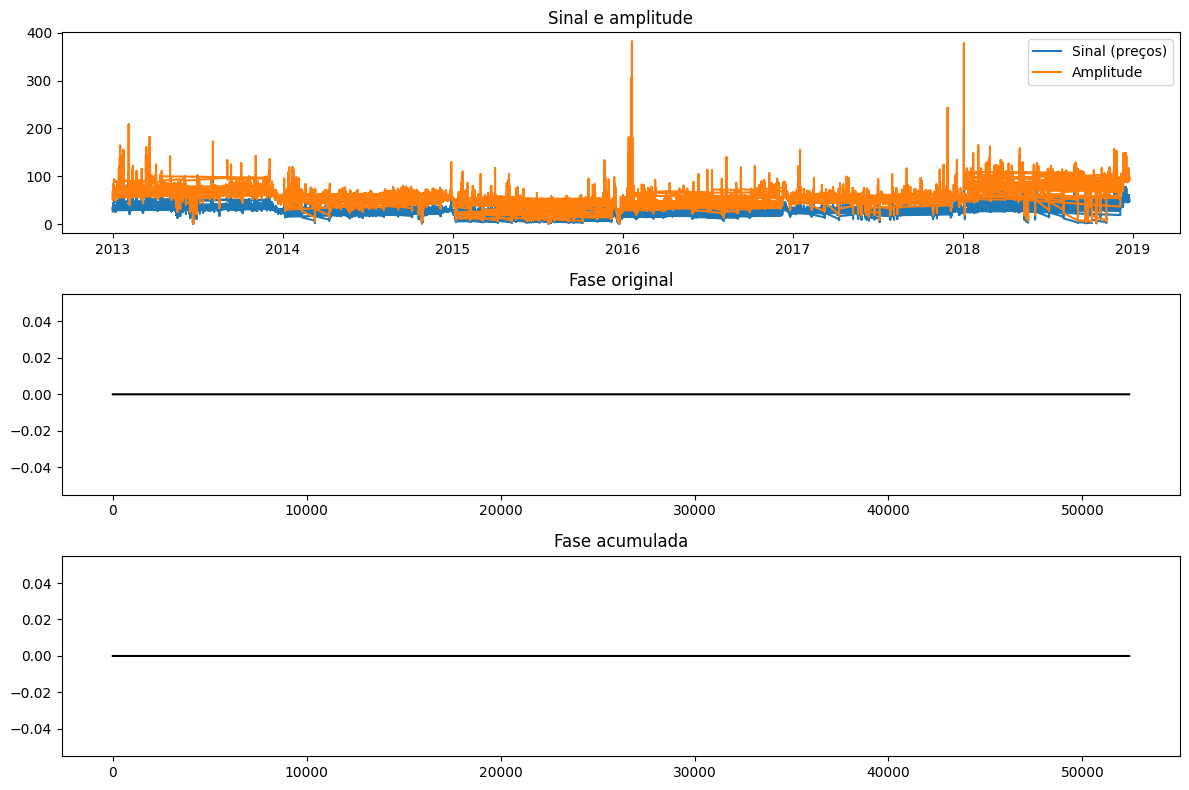

In [10]:
fig, ax = plt.subplots(3,1, figsize=(12,8))

ax[0].plot(nordpool[' Price'], label='Sinal (preços)')
ax[0].plot(100000*nordpool['Amplitude'], label='Amplitude')
ax[0].legend(loc='upper right')
ax[0].set_title('Sinal e amplitude')

ax[1].plot(fase, color='black')
ax[1].set_title('Fase original')

ax[2].plot(fase_acm, color='black')
ax[2].set_title('Fase acumulada')

plt.tight_layout()

## Segunda tentativa de aplicação de Fourier

Dear Vitor,

many thanks for your message. While I do not hold a copy of the R code used in the project, it should be fairly straightforward to implement the details. One just needs to perform a Fourier transform in R, then setting the values with negative (and vanishing) frequency to zero, and finally doing an inverse transform. That gives a complex valued time series, where the absolute value is (up to a factor 2) the time varying amplituce (the envelope) and the complex phase is the phase of the signal (which one still needs to lift to avoid discontinuieties, but there are commands for that as well). There is a fully fledged command in R that can be used as well

https://search.r-project.org/CRAN/refmans/gsignal/html/hilbert.html
Does that help?

Best wishes

wolfram

In [11]:
nordpool = nordpool[' Price']

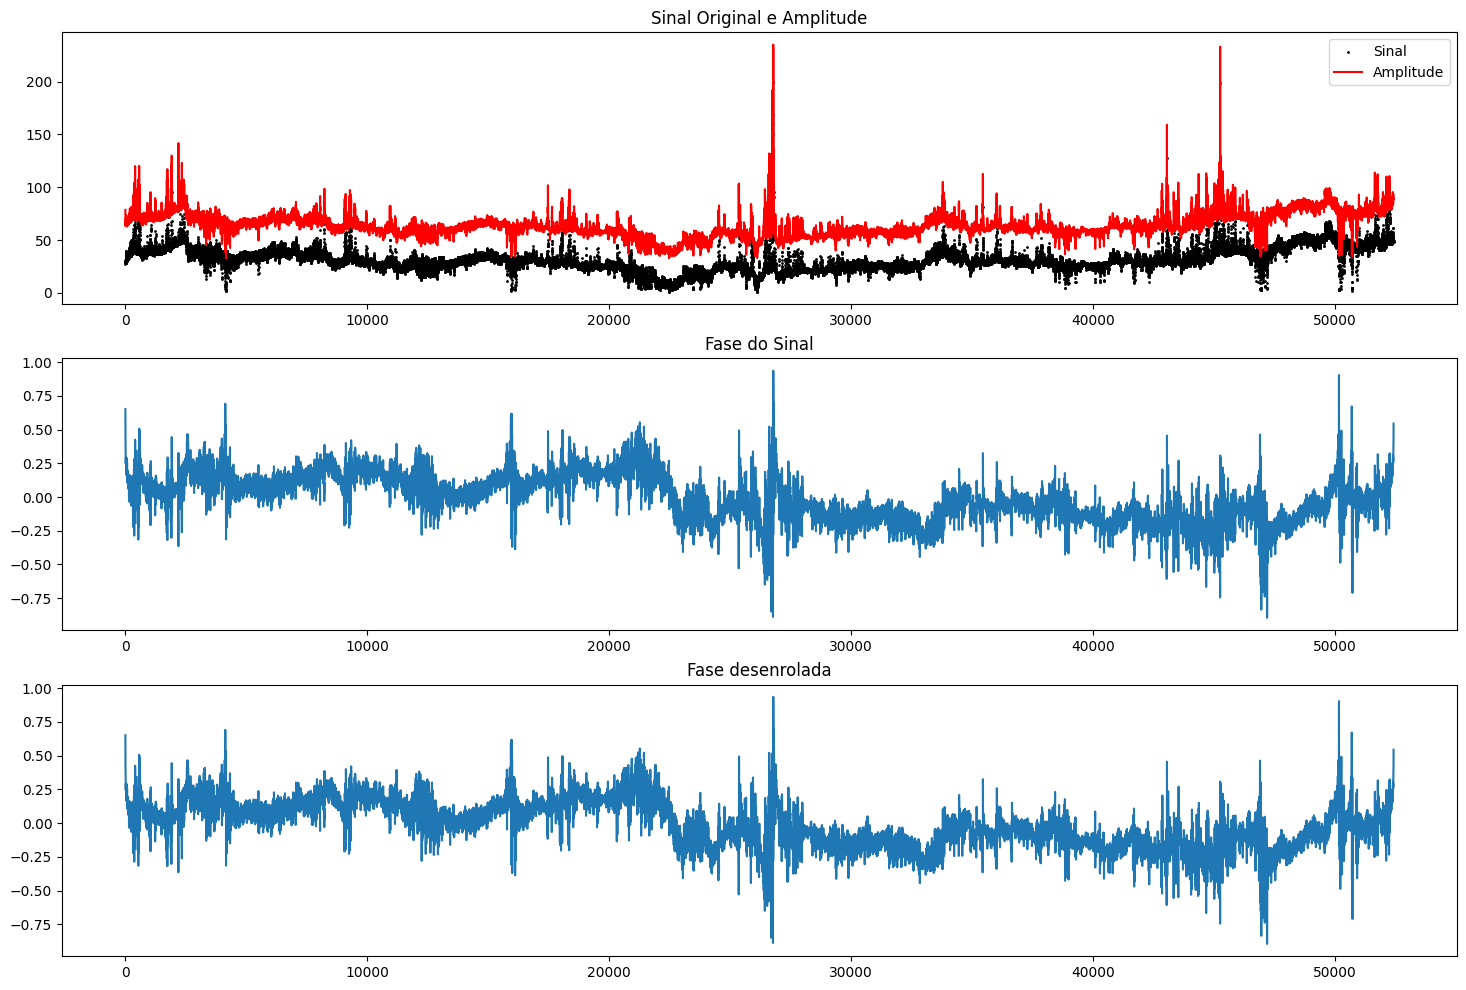

In [12]:
# Calcular a Transformada de Fourier
n = len(nordpool)
z = np.fft.fft(nordpool)
freq = np.fft.fftfreq(n)

# Zerar os valores com frequência negativa (apenas para considerar a parte positiva)
z[freq < 0] = 0

# Calcular a Transformada Inversa de Fourier
w = np.fft.ifft(z)

fase = np.angle(w)

fase_acm = np.unwrap(fase)

# Plotar os resultados
plt.figure(figsize=(18, 12))

plt.subplot(3, 1, 1)
plt.scatter(range(n), nordpool, s=1, label='Sinal', color='black')
plt.plot(2*np.abs(w), label='Amplitude', color='red')
plt.title('Sinal Original e Amplitude')
plt.legend(loc='upper right')

plt.subplot(3, 1, 2)
plt.plot(fase)
plt.title('Fase do Sinal')

plt.subplot(3, 1, 3)  #não se fez necessário pois a fase original não apresenta saltos superiores a 2pi
plt.plot(fase_acm)
plt.title('Fase desenrolada')

#plt.tight_layout()
plt.show()